In [1]:
# ## note these to add w/Poetry to the Dockerfile
# %pip install pandas
# %pip install networkx
# %pip install scipy

In [2]:
import os 
import tensorflow as tf
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.spatial.distance import pdist
from tensorflow.keras.layers import Dense, Multiply, Add
from tensorflow.keras import Model
from tensorflow.keras.constraints import NonNeg 
from tensorflow.python.ops.numpy_ops import np_config
os.chdir('..')
from src.data_cleaning import *
from src.mds_model import *
np_config.enable_numpy_behavior()


In [3]:
url = 'http://cs.bc.edu/~prudhome/AAPLD/animal-similarity.csv'

raw_dataset = pd.read_csv(url, index_col=0)
list_of_animal_pairs = raw_dataset.index.str.split('~')

In [4]:
animal_pair_data = pd.DataFrame.from_records(list_of_animal_pairs, columns=['first_animal', 'second_animal'], index= raw_dataset.index)

In [5]:
animal_pair_data.sort_values(by = ['first_animal', 'second_animal'], inplace=True)

In [6]:
unique_animals = set(animal_pair_data.first_animal).union(animal_pair_data.second_animal)

In [7]:
animal_pairs = nx.Graph()
animal_pairs.add_nodes_from(unique_animals)
animal_pairs.add_edges_from(list_of_animal_pairs)

In [8]:
low_degree=[k for k,v in animal_pairs.degree._nodes.items() if len(v) < 32]

In [9]:
animal_pairs.remove_nodes_from(low_degree)

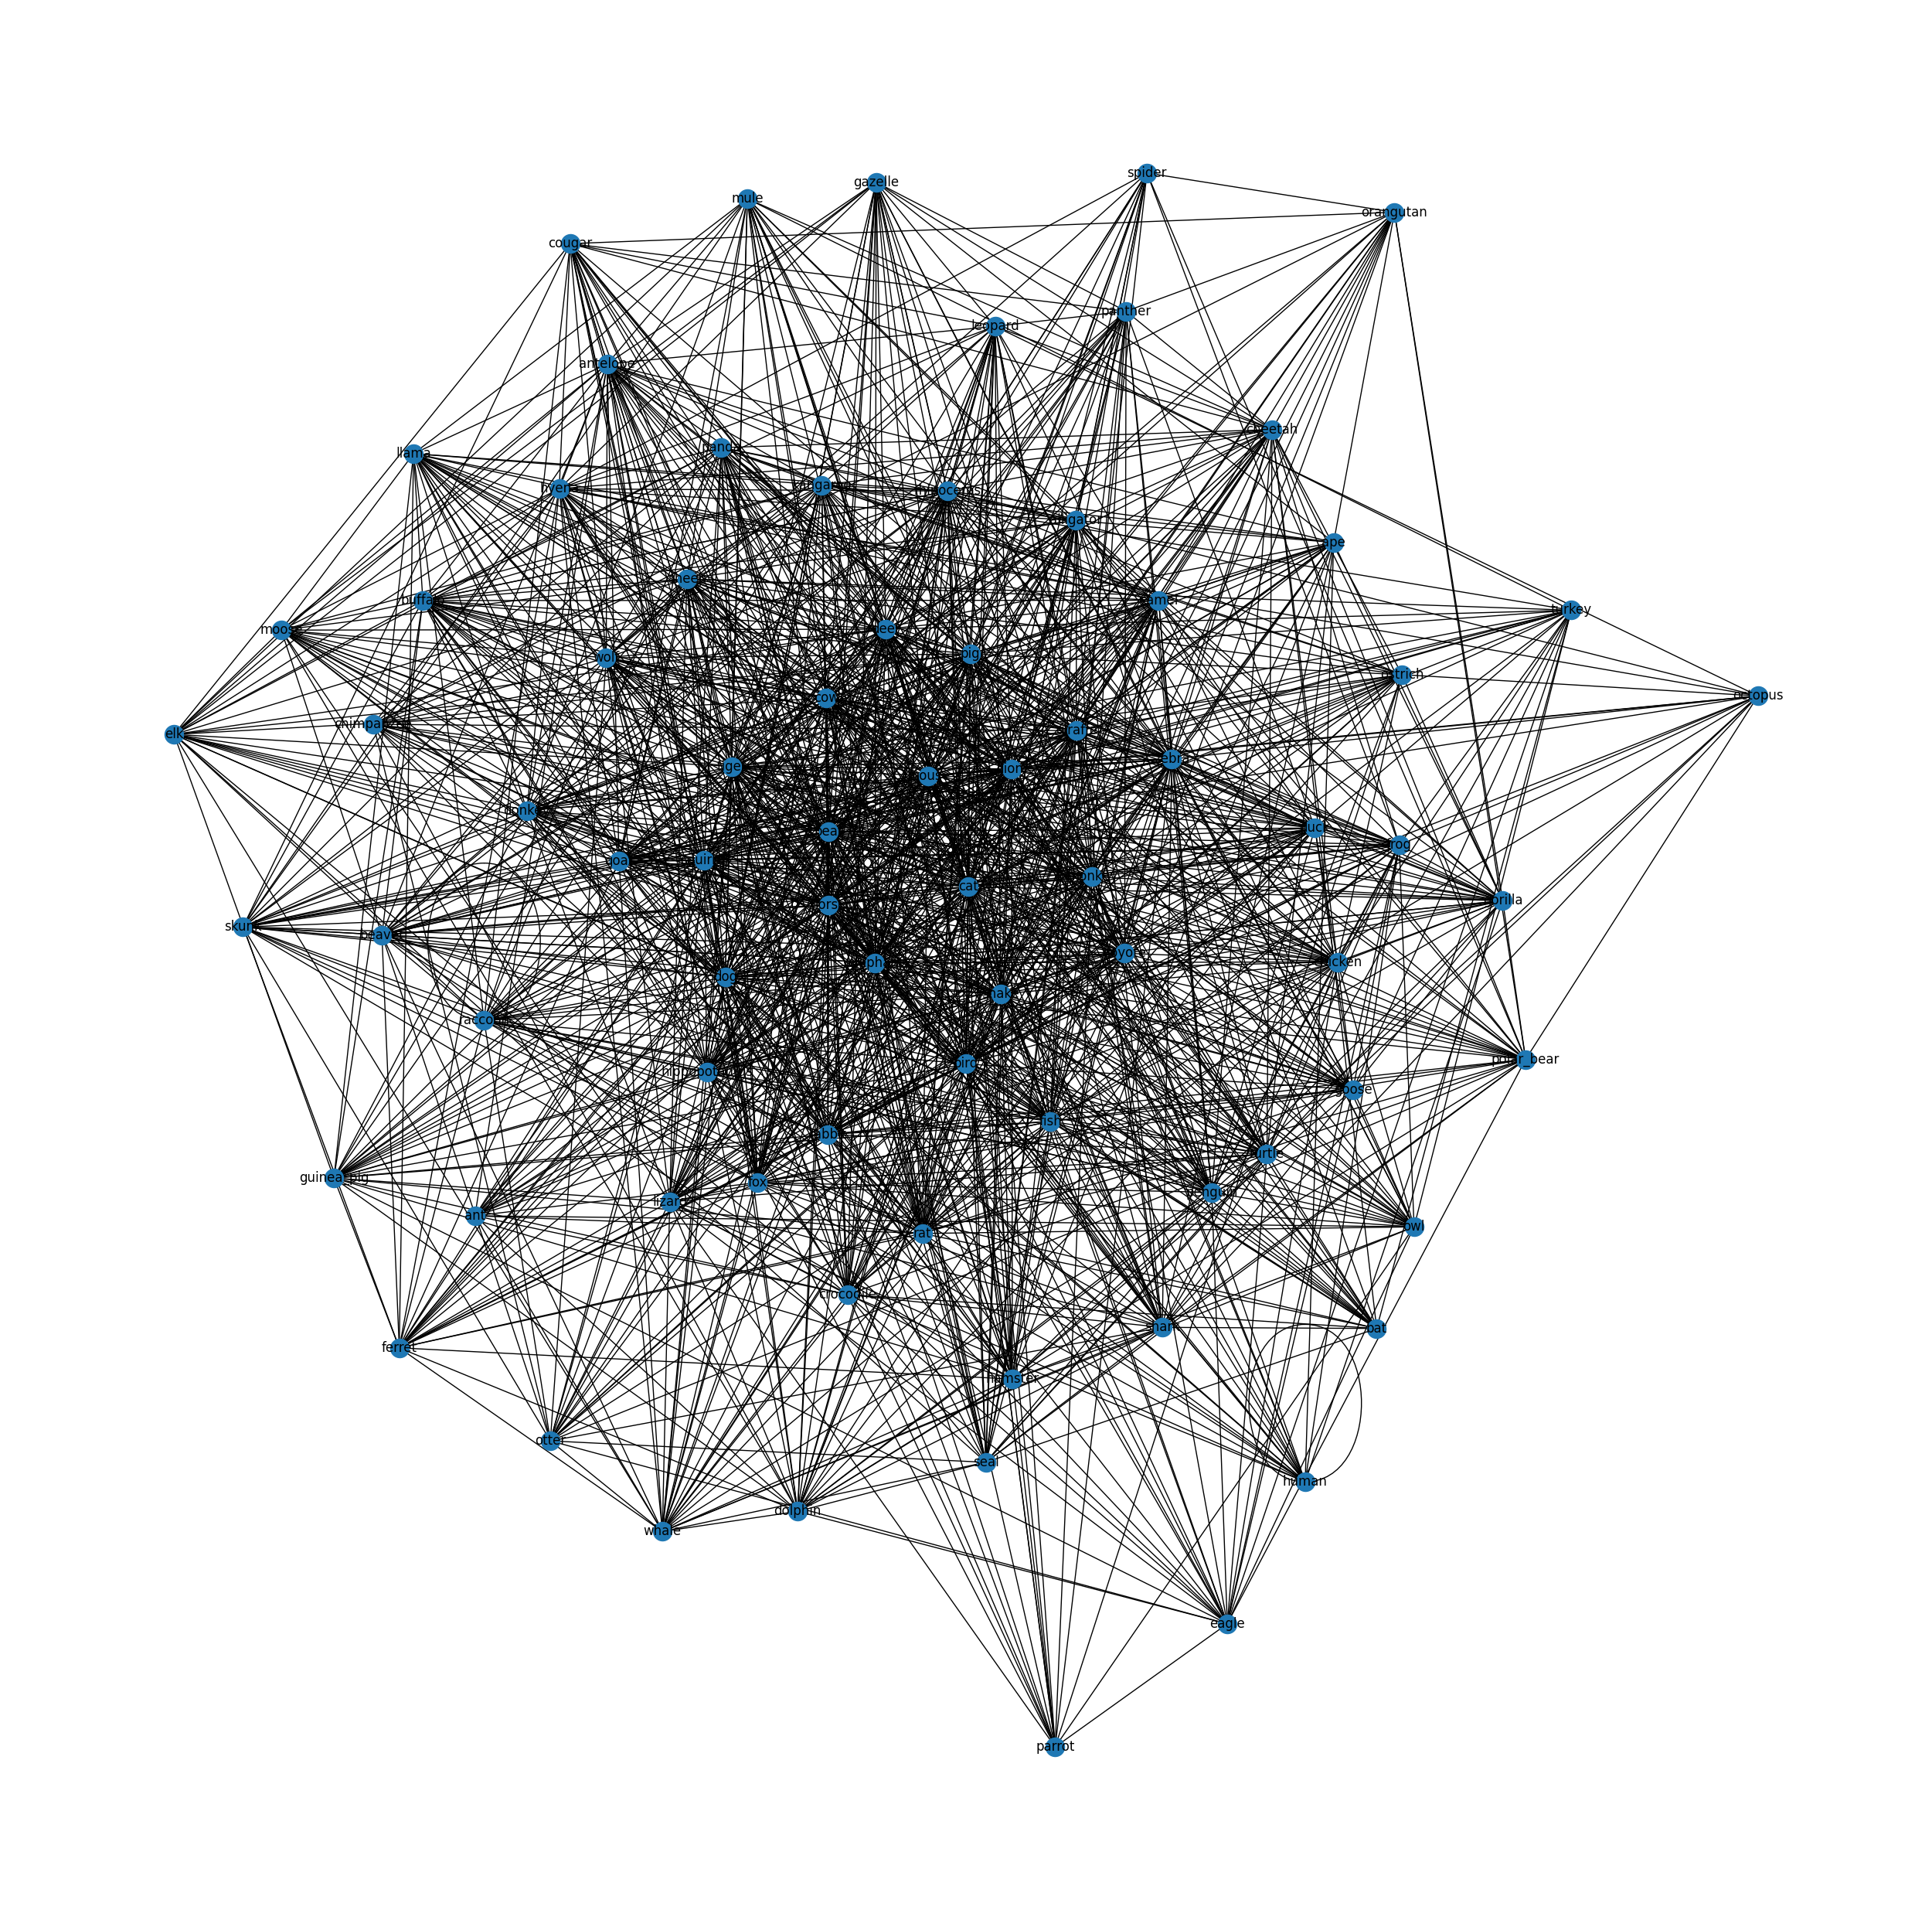

In [10]:
fig, ax = plt.subplots(figsize=(32,32))
nx.draw(animal_pairs, with_labels=True, ax=ax)

plt.show()

In [11]:
connected_list = [x for x in animal_pairs.nodes]

In [12]:
# try the small list, or, failing that, just the apes

In [13]:
smaller_animal_pair_data=animal_pair_data.loc[animal_pair_data['first_animal' ].isin( connected_list) & animal_pair_data['second_animal' ].isin( connected_list) ] 

In [14]:
joined_data=smaller_animal_pair_data.join(raw_dataset).drop(columns='[All_Ratings]')

In [15]:
big_matrix = pd.DataFrame(index=connected_list, columns = connected_list)

In [16]:
joined_data

first_animal second_animal  Average_Rating
Pair                                                         
alligator~antelope    alligator      antelope           1.940
alligator~bird        alligator          bird           2.080
alligator~buffalo     alligator       buffalo           1.080
alligator~elephant    alligator      elephant           1.140
alligator~fish        alligator          fish           1.000
...                         ...           ...             ...
zebra~seal                zebra          seal           1.040
zebra~shark               zebra         shark           1.067
zebra~snake               zebra         snake           1.880
zebra~tiger               zebra         tiger           2.720
zebra~turtle              zebra        turtle           1.120

[1601 rows x 3 columns]

In [17]:
#TODO wrap below section into functions

In [18]:
for row in joined_data.iterrows():
    big_matrix.loc[row[1].first_animal][row[1].second_animal] = row[1].Average_Rating
    big_matrix.loc[row[1].second_animal][row[1].first_animal] = row[1].Average_Rating

In [19]:
big_matrix = big_matrix.astype(float)

In [20]:
# big_matrix = big_matrix[big_matrix.isna().mean(1) < 0.5]
# big_matrix = big_matrix[big_matrix.index.to_list()]

In [21]:
big_matrix = big_matrix[big_matrix.isna().mean(1) < 0.33]

In [22]:
big_matrix = big_matrix[big_matrix.index.to_list()]

In [23]:
plt.matshow(big_matrix)

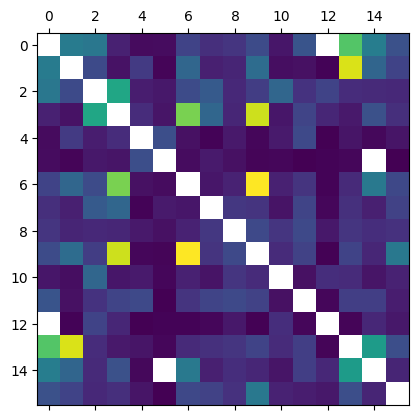

In [24]:
plt.show()

In [25]:
big_matrix.isna().mean(1)

deer        0.1250
zebra       0.0625
dog         0.0625
cat         0.0625
snake       0.0625
fish        0.1250
tiger       0.0625
pig         0.0625
elephant    0.0625
lion        0.0625
monkey      0.0625
bear        0.0625
bird        0.1250
horse       0.0625
cow         0.1250
giraffe     0.0625
dtype: float64

In [26]:
big_matrix.shape

(16, 16)

In [27]:
big_matrix

deer  zebra    dog    cat  snake   fish  tiger    pig  elephant  \
deer       NaN  3.180  3.060  1.480   1.16  1.180  2.040  1.700     1.800   
zebra     3.18    NaN  2.175  1.260   1.88  1.080  2.720  1.460     1.550   
dog       3.06  2.175    NaN  4.080   1.42  1.340  2.200  2.480     1.600   
cat       1.48  1.260  4.080    NaN   1.66  1.300  5.160  2.717     1.560   
snake     1.16  1.880  1.420  1.660    NaN  2.260  1.240  1.060     1.360   
fish      1.18  1.080  1.340  1.300   2.26    NaN  1.180  1.370     1.240   
tiger     2.04  2.720  2.200  5.160   1.24  1.180    NaN  1.320     1.500   
pig       1.70  1.460  2.480  2.717   1.06  1.370  1.320    NaN     1.840   
elephant  1.80  1.550  1.600  1.560   1.36  1.240  1.500  1.840       NaN   
lion      2.20  2.840  1.940  5.820   1.10  1.067  6.220  1.780     2.160   
monkey    1.32  1.200  2.720  1.320   1.38  1.100  1.480  1.280     1.810   
bear      2.36  1.240  1.760  2.080   2.16  1.000  1.780  2.080     2.160   
bird       NaN  1.060  2.050  1.560   1.00  1.060  1.060  1.100     1.340   
horse     4.82  5.917  1.660  1.360   1.30  1.100  1.620  1.720     1.800   
cow       3.22  2.700  1.620  2.300   1.11    NaN  3.117  1.460     1.683   
giraffe   2.30  2.040  1.600  1.700   1.30  1.020  2.125  2.020     1.740   

           lion  monkey   bear  bird  horse    cow  giraffe  
deer      2.200    1.32  2.360   NaN  4.820  3.220    2.300  
zebra     2.840    1.20  1.240  1.06  5.917  2.700    2.040  
dog       1.940    2.72  1.760  2.05  1.660  1.620    1.600  
cat       5.820    1.32  2.080  1.56  1.360  2.300    1.700  
snake     1.100    1.38  2.160  1.00  1.300  1.110    1.300  
fish      1.067    1.10  1.000  1.06  1.100    NaN    1.020  
tiger     6.220    1.48  1.780  1.06  1.620  3.117    2.125  
pig       1.780    1.28  2.080  1.10  1.720  1.460    2.020  
elephant  2.160    1.81  2.160  1.34  1.800  1.683    1.740  
lion        NaN    1.64  2.020  1.04  2.040  1.560    3.100  
monkey    1.640     NaN  1.240  1.68  1.640  1.290    1.500  
bear      2.020    1.24    NaN  1.10  1.960  1.960    1.425  
bird      1.040    1.68  1.100   NaN  1.080  1.580    1.340  
horse     2.040    1.64  1.960  1.08    NaN  3.860    2.250  
cow       1.560    1.29  1.960  1.58  3.860    NaN    1.540  
giraffe   3.100    1.50  1.425  1.34  2.250  1.540      NaN

In [28]:
# todo make into function
similarities = big_matrix.to_numpy()
similarity_vec = np.tril(similarities, -1)
similarity_vec = similarity_vec[np.nonzero(similarity_vec)]

In [29]:
# FIll in NA's 

In [30]:
similarity_vec = np.nan_to_num(similarity_vec, nan=min(similarity_vec))

In [31]:
dissimilarity_vec = np.exp(-1*similarity_vec)

In [32]:
len(dissimilarity_vec) 
# :=Y  = n(n-1)/2
# 2Y = n^2 - n
# 0 = n^2 - n - 2Y

# 0 = (n - 1/2) ^2 - 1/4 - 2Y 
# 2Y + 1/4 = (n - 1/2)^2
# N = 1/2 + sqrt(2Y + 1/4)


120

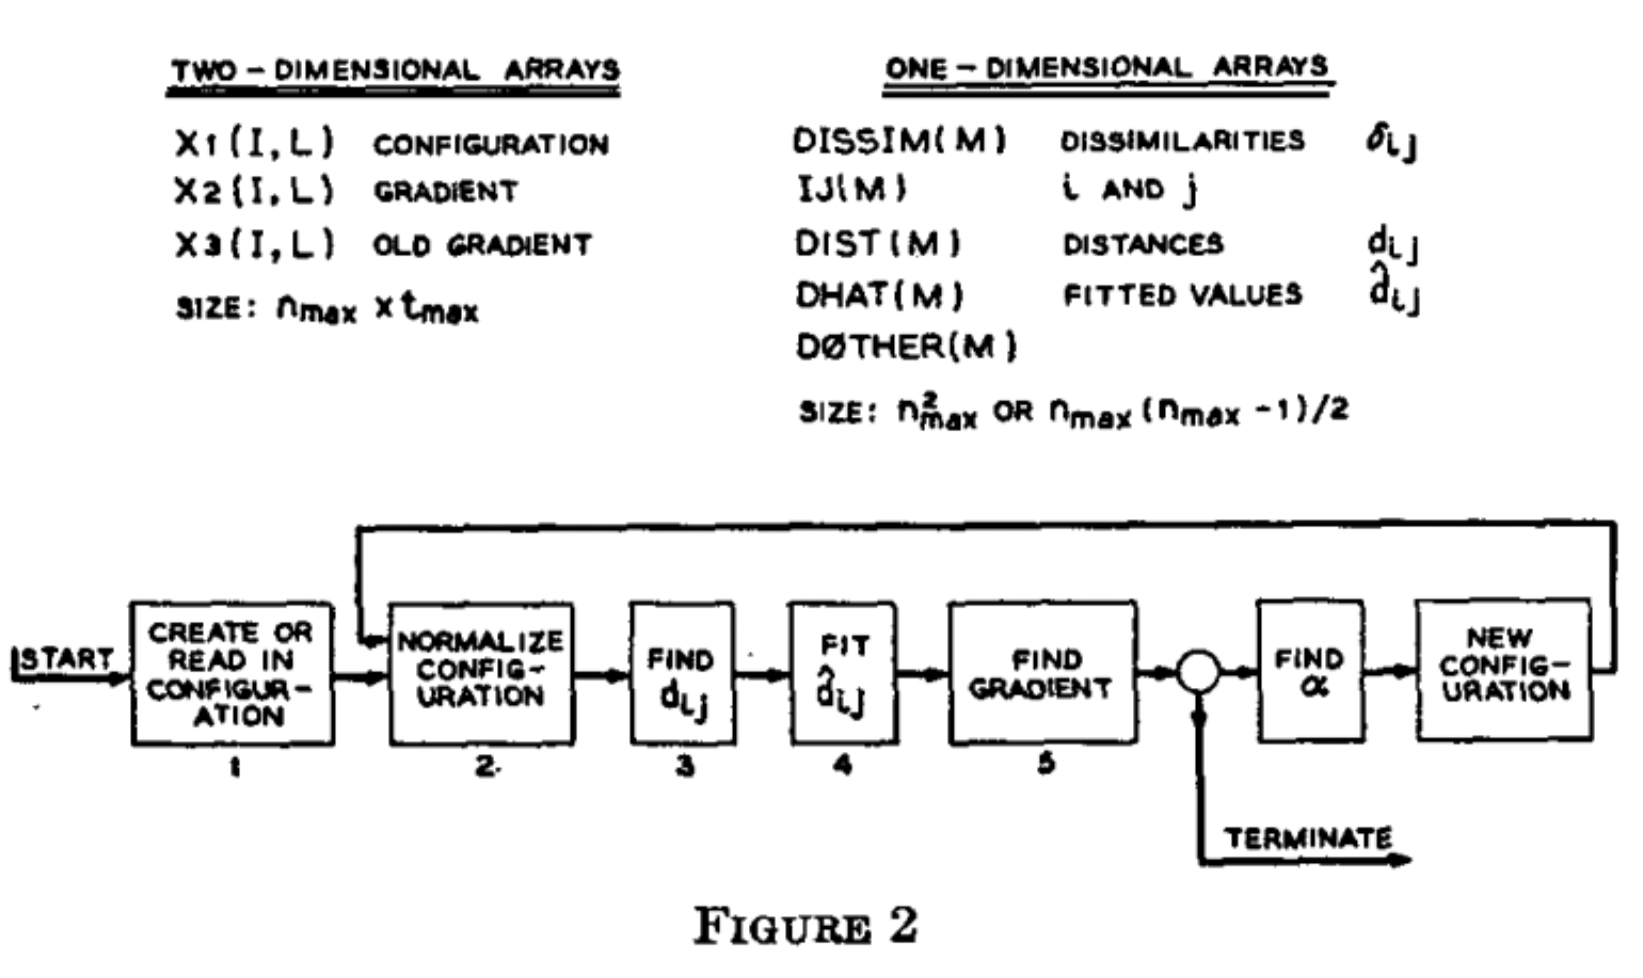
From Kruskal, 1964

Idea is to follow these steps, 

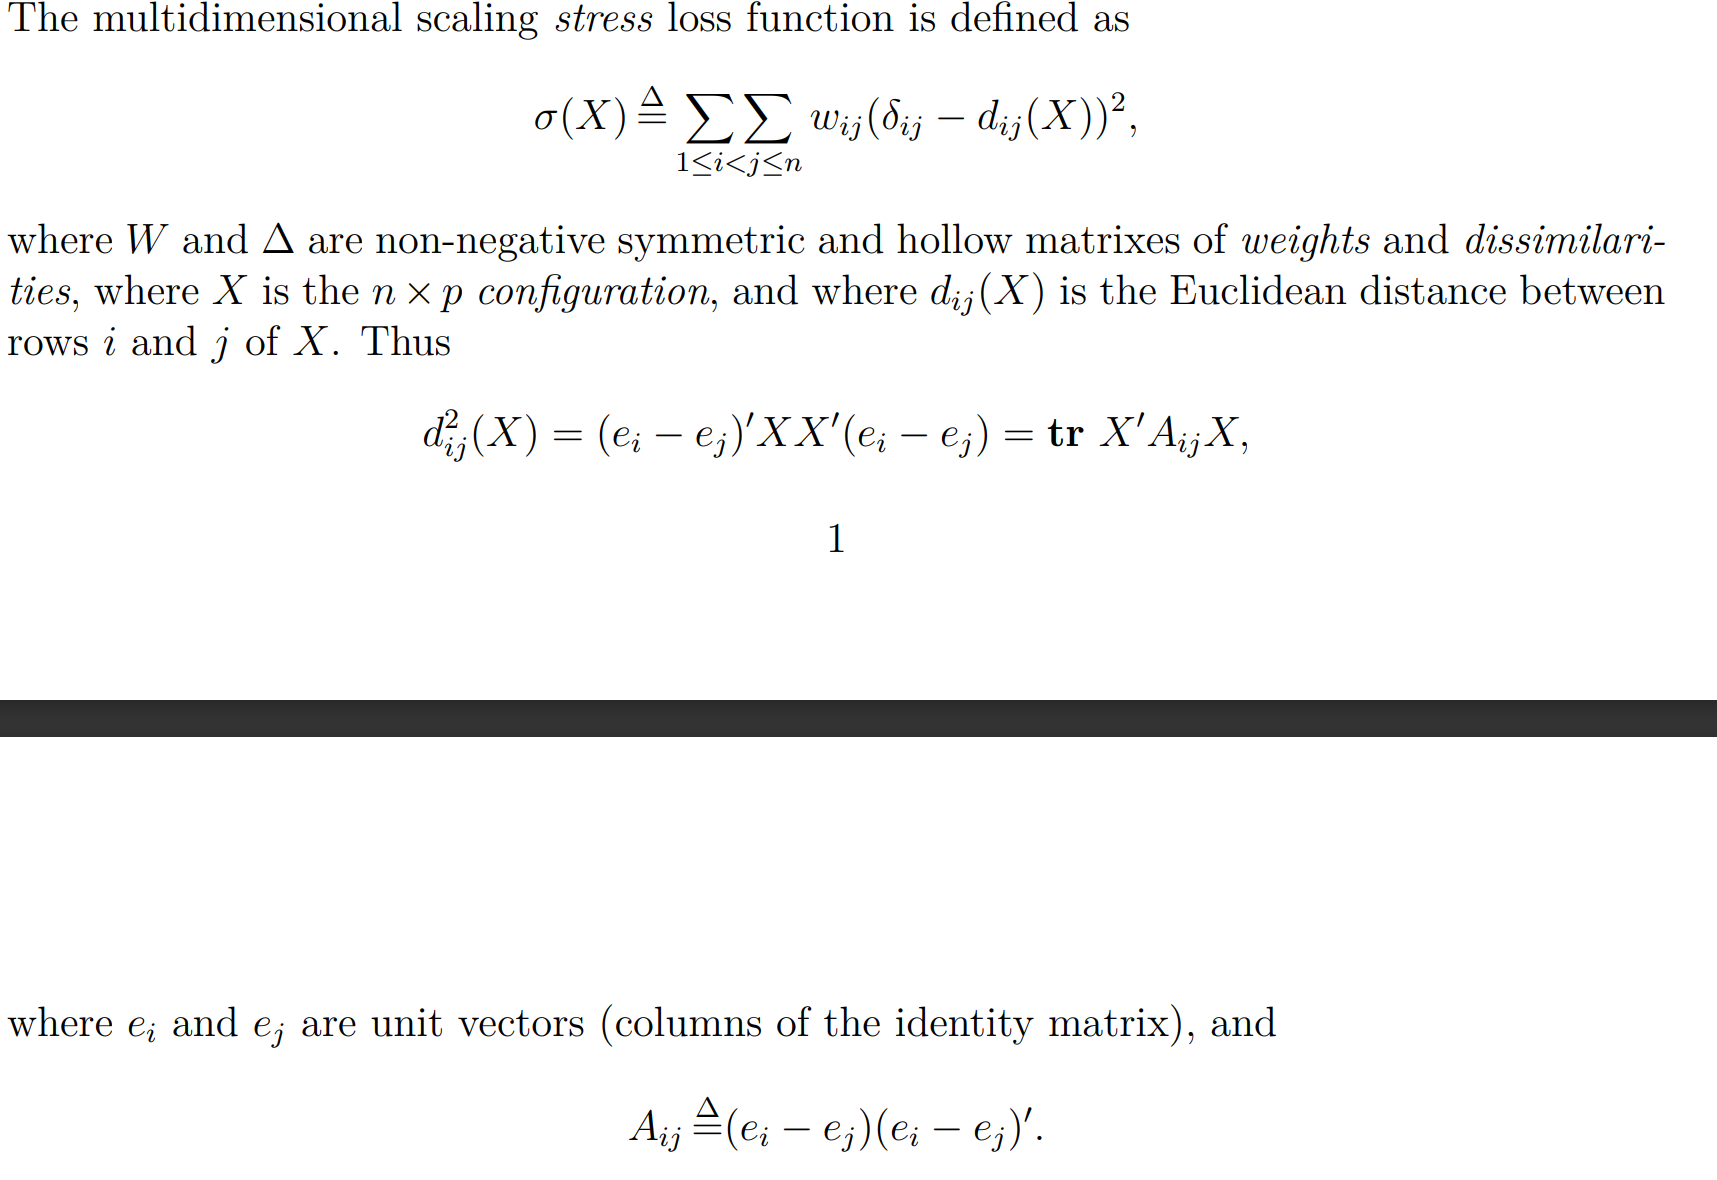
From https://jansweb.netlify.app/publication/deleeuw-e-18-c/
NB: $\delta_{ij}$ here is the true dissimilarity between $i$ and $j$ 

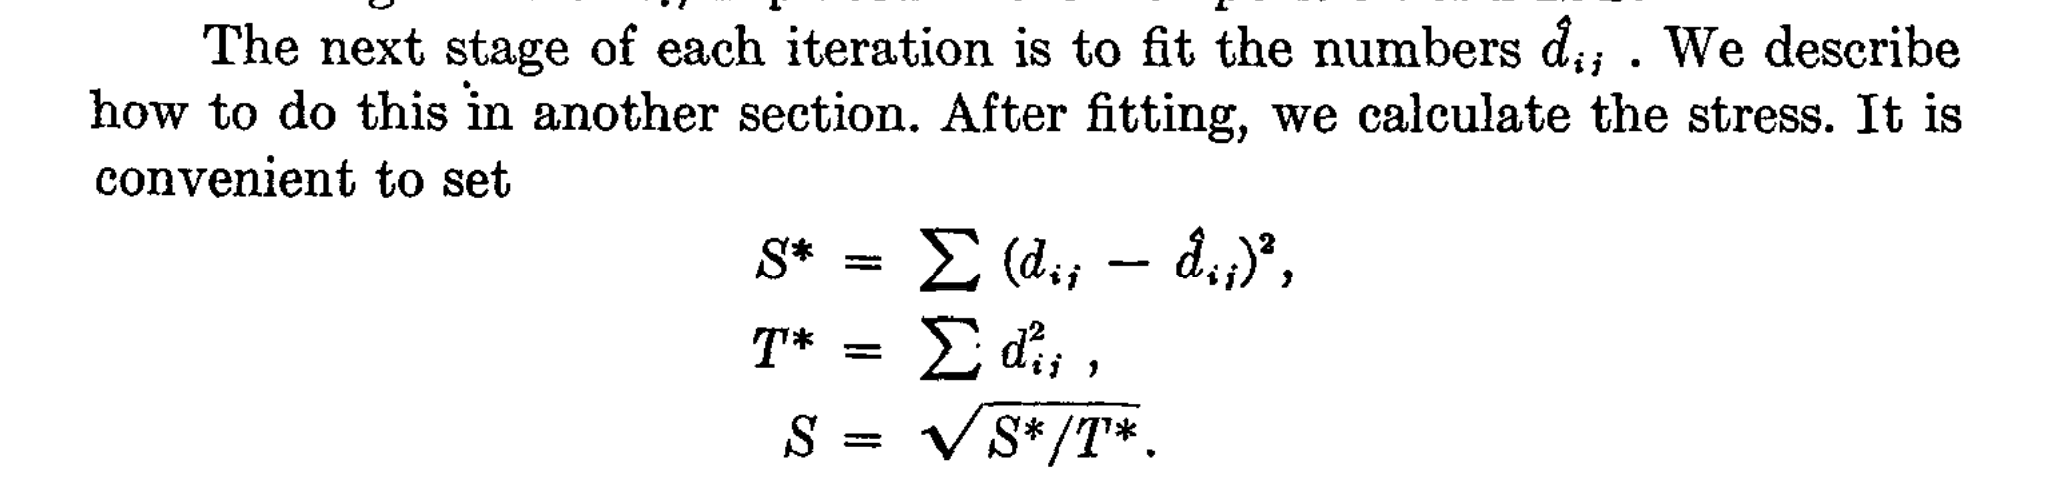
Stress Loss function from Kruskal, 1964

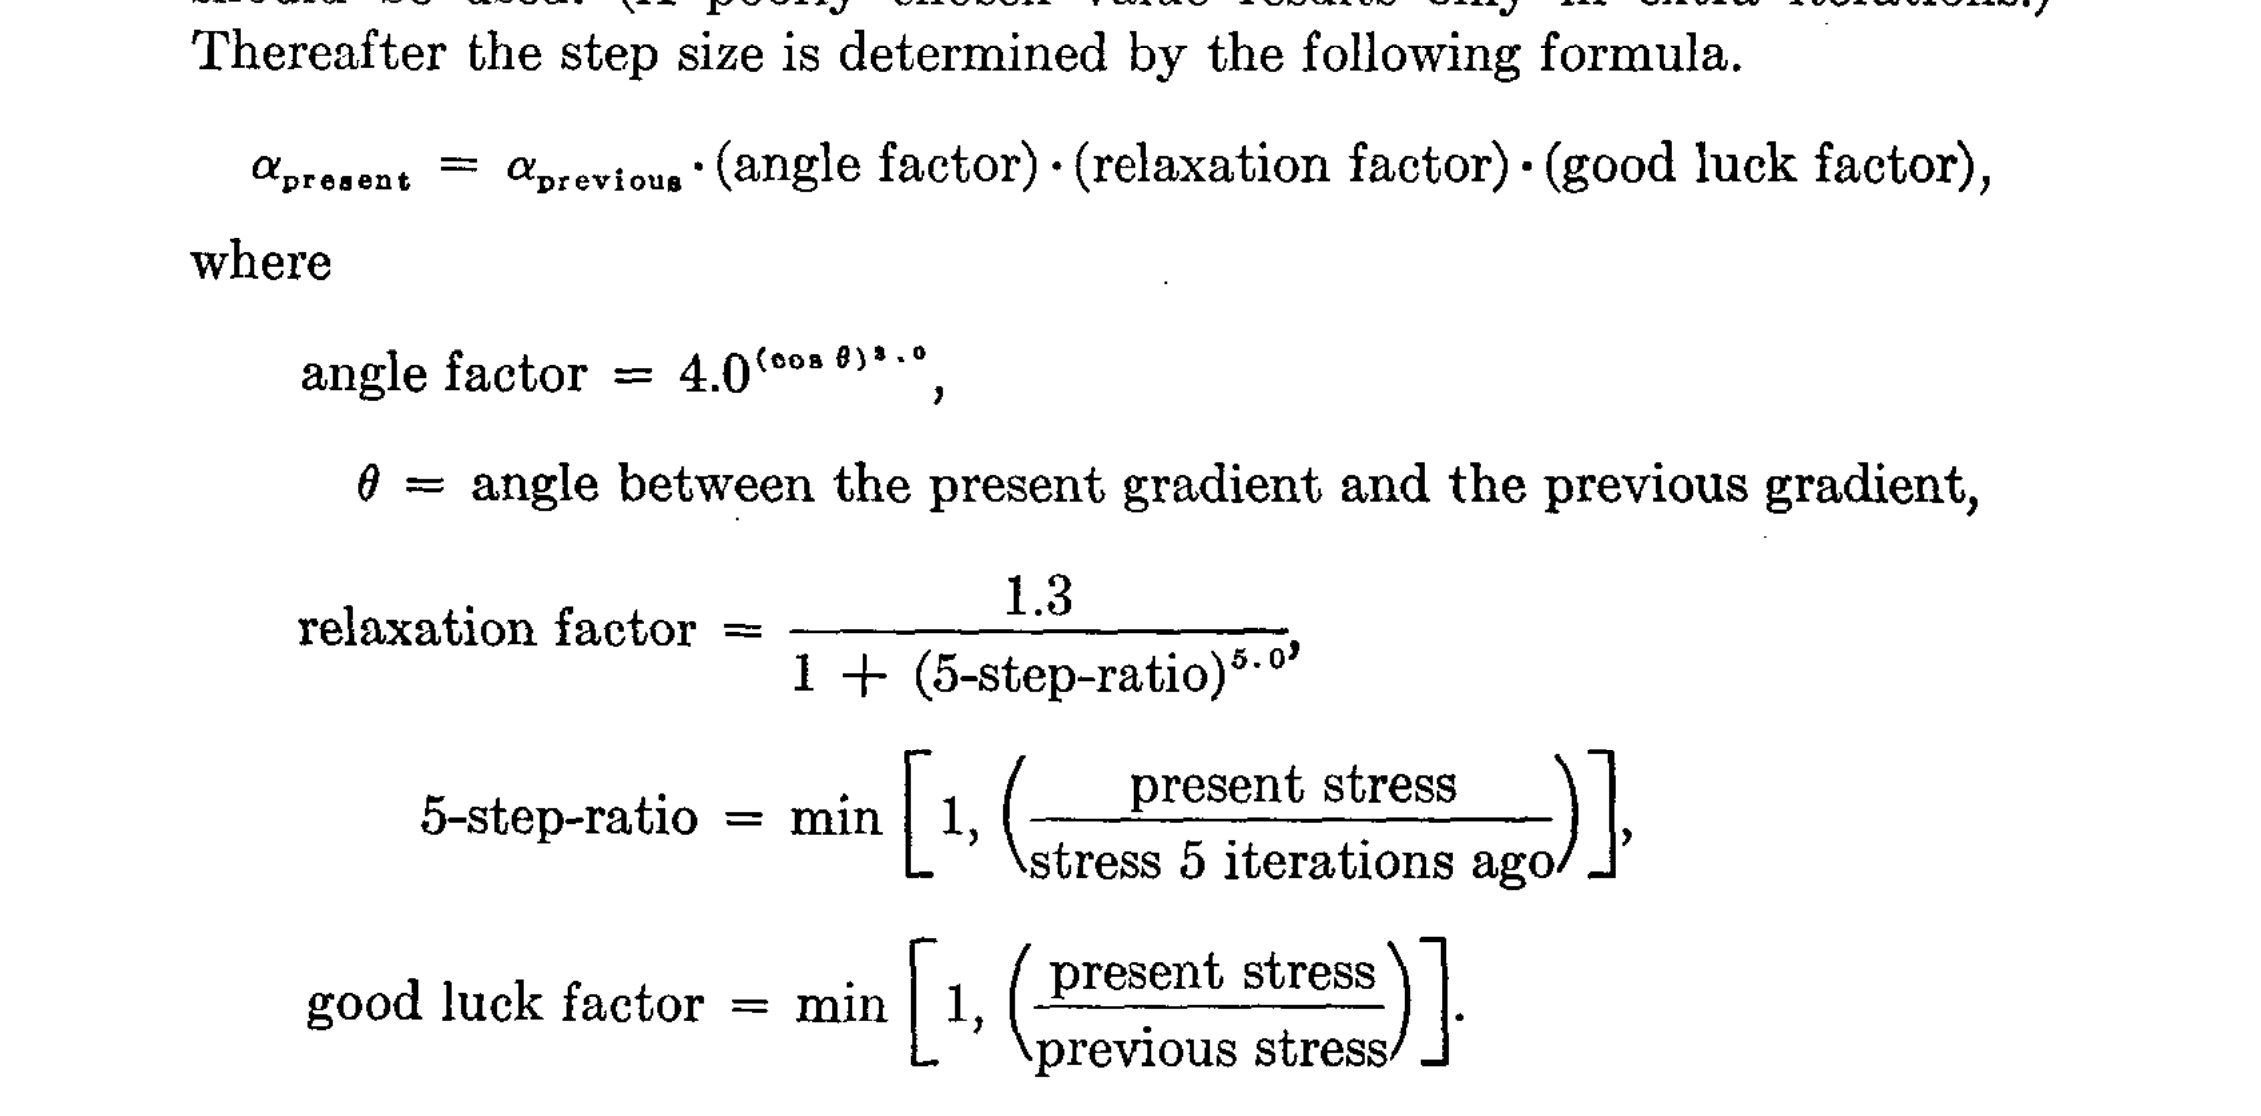
Optimizer from Kruskal, 1964

In [33]:
## Steps 
### Define configuration 
#### for each training iteration
#### normalize 
#### find pairwise distances
#### monotone regression
#### gradient descent



In [34]:
start_config = generate_starting_configuration(dissimilarity_vec, len(big_matrix.index))
start_tf_config = tf.convert_to_tensor(start_config)
start_tf_config = tf.keras.utils.normalize(start_tf_config, axis=0)
start_tf_config = tf.keras.utils.normalize(start_tf_config, axis=1)
start_tf_config=start_config
configuration = start_config

In [51]:
len(big_matrix.index)

16

In [49]:
disty = PDistLayer()
disty(start_tf_config)

<tf.Tensor: shape=(1, 153), dtype=float64, numpy=
array([[  1.,   5.,   5.,   1.,   8.,   4.,  10.,   1.,  13.,  10.,   4.,
         13.,   1.,  18.,   9.,  17.,   4.,  20.,   1.,  25.,  17.,   9.,
         20.,   4.,  25.,   1.,  32.,  16.,  26.,   9.,  29.,   4.,  34.,
          1.,  41.,  26.,  16.,  29.,   9.,  34.,   4.,  41.,   1.,  50.,
         25.,  37.,  16.,  40.,   9.,  45.,   4.,  52.,   1.,  61.,  37.,
         25.,  40.,  16.,  45.,   9.,  52.,   4.,  61.,   1.,  72.,  36.,
         50.,  25.,  53.,  16.,  58.,   9.,  65.,   4.,  74.,   1.,  85.,
         50.,  36.,  53.,  25.,  58.,  16.,  65.,   9.,  74.,   4.,  85.,
          1.,  98.,  49.,  65.,  36.,  68.,  25.,  73.,  16.,  80.,   9.,
         89.,   4., 100.,   1., 113.,  65.,  49.,  68.,  36.,  73.,  25.,
         80.,  16.,  89.,   9., 100.,   4., 113.,   1., 128.,  64.,  82.,
         49.,  85.,  36.,  90.,  25.,  97.,  16., 106.,   9., 117.,   4.,
        130.,   1., 145.,  82.,  64.,  85.,  49.,  90.,  36., 

In [36]:
with tf.GradientTape() as tape:
    pdists = get_pairwise_distances(configuration)
gradient = tape.gradient(pdists, configuration)

In [37]:
gradient

In [38]:
# The monotone regression: wrap in function
configuration = deepcopy(start_config)
model = MDSModel(configuration)
model.compile(optimizer='adam', loss=stress)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
loss_object = stress

In [39]:
train_loss = tf.keras.metrics.Mean(name='train_loss')

In [40]:
@tf.function
def train_step(config, dis_vec):
    with tf.GradientTape(persistent=False) as tape:
#         tape.watch(config)
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
        predictions = model(config, training=True)
        print("made predictions")
        loss = loss_object(dis_vec, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    print(gradients)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    return predictions 

In [41]:
# train_step(start_tf_config, dissimilarity_vec)
model = MDSModel(start_tf_config)

In [42]:
model.compile()

In [43]:
model.trainable_variables


[<tf.Variable 'initial_config:0' shape=(18, 2) dtype=float64, numpy=
 array([[1., 0.],
        [0., 1.],
        [2., 0.],
        [0., 2.],
        [3., 0.],
        [0., 3.],
        [4., 0.],
        [0., 4.],
        [5., 0.],
        [0., 5.],
        [6., 0.],
        [0., 6.],
        [7., 0.],
        [0., 7.],
        [8., 0.],
        [0., 8.],
        [9., 0.],
        [0., 9.]])>,
 <tf.Variable 'derived_config:0' shape=(18, 2) dtype=float64, numpy=
 array([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]])>]

In [44]:
#looks like gradient loss is messed up by the distance step! What to do next 

In [45]:
@tf.function
def train_step(config, dis_vec):
    with tf.GradientTape(persistent=False) as tape:
        tape.watch(config)
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
        predictions = model(config, training=True)
        print("made predictions")
        loss = loss_object(dis_vec, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    print(gradients)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    return predictions 

In [46]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.1)
min_loss = 1e6
train_loss.reset_states()

preds = train_step(configuration, dissimilarity_vec)
diff = -10 
for epoch in range(50):
    while abs(diff) >= 1e-3:
# normalize! 
    #TODO: Convert to pure tf
        configuration/=np.linalg.norm(configuration)
    # pairwise dist 
    ### Two options here: 
    #### 1. (suboptimal) use the "canned" formulas for the gradient and just use TF for the monotone regression
    #### 2. write the first layer after the inputs to compute pairwise distances and then to vectorize the lower tri, followed by a couple dense layers 
        old_loss = train_loss.result()
    # Reset the metrics at the start of the next epoch
        train_loss.reset_states()

        preds = train_step(configuration, dissimilarity_vec)

        # Now, apply the gradient of the stress to update the configuration 


        print(f'Epoch {epoch + 1}, Loss: {train_loss.result()}')
        diff = train_loss.result() - old_loss
        print(f'Diff: {diff}')



made predictions


ValueError: in user code:

    File "<ipython-input-45-6aebdee13b3e>", line 9, in train_step  *
        loss = loss_object(dis_vec, predictions)
    File "/tf/src/mds_model.py", line 88, in stress  *
        Sstar = tf.math.reduce_sum(tf.math.square(y_true - y_pred),axis=-1)

    ValueError: Dimensions must be equal, but are 120 and 153 for '{{node sub}} = Sub[T=DT_DOUBLE](y_true, sub/Cast)' with input shapes: [120], [1,153].


In [ ]:
model.summary()

In [ ]:
preds

In [ ]:
plt.scatter(dissimilarity_vec, preds)
plt.show()

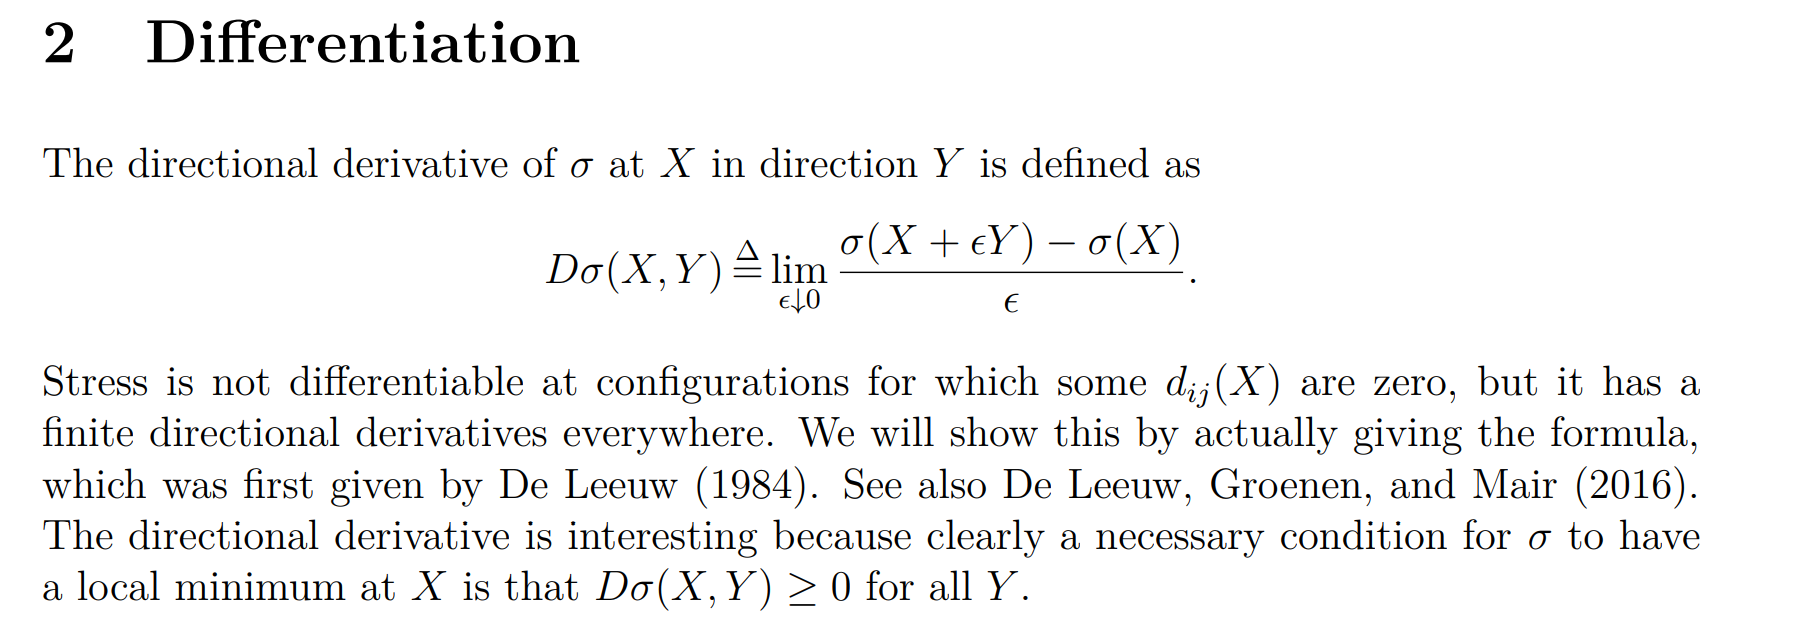
From https://jansweb.netlify.app/publication/deleeuw-e-18-c/

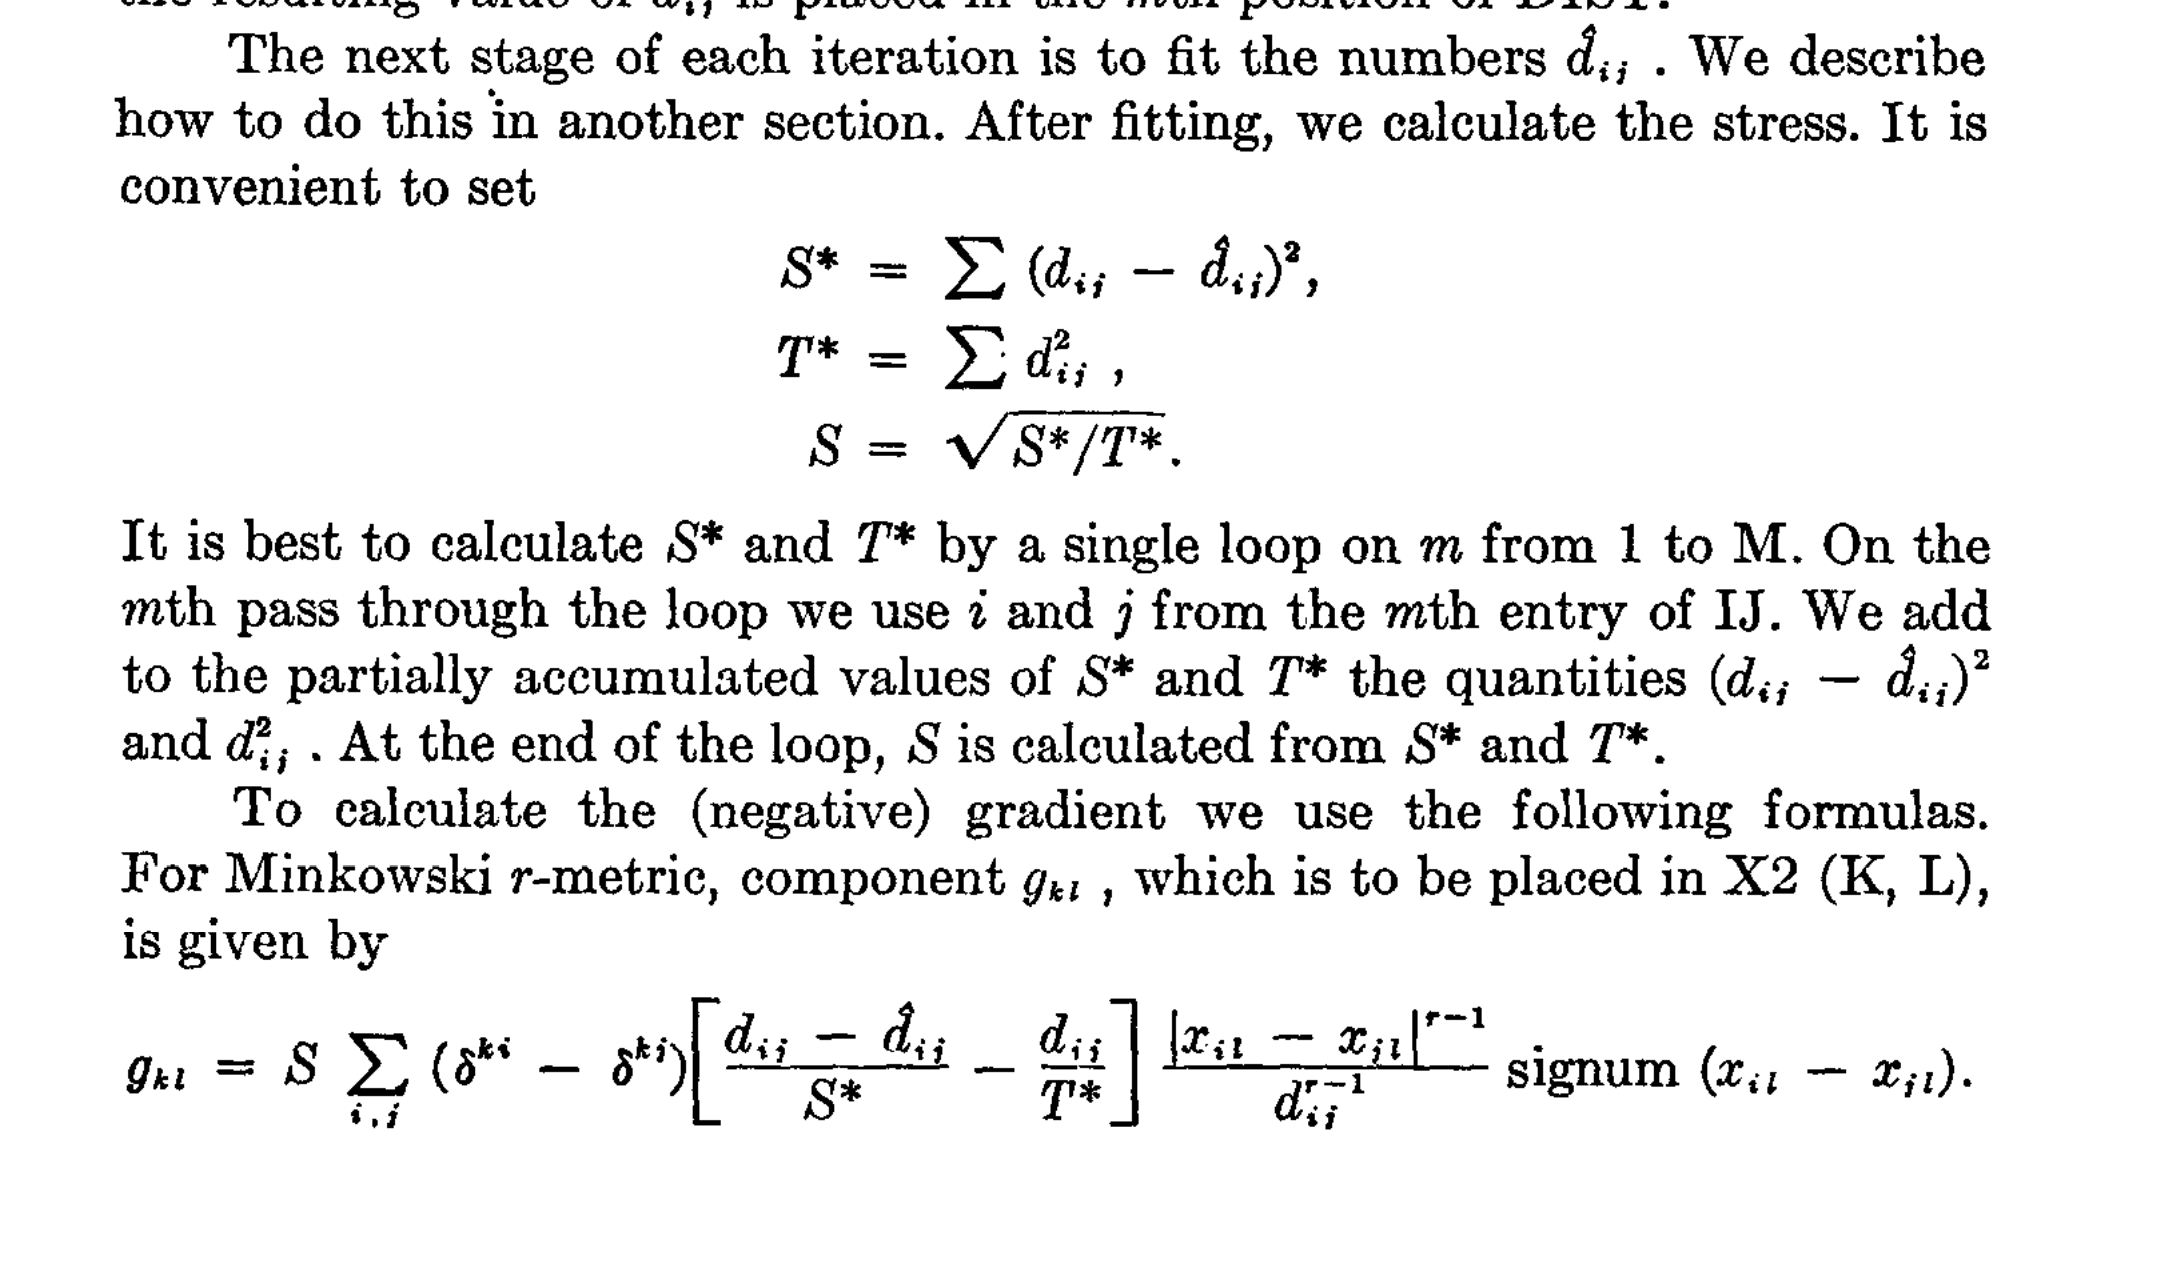
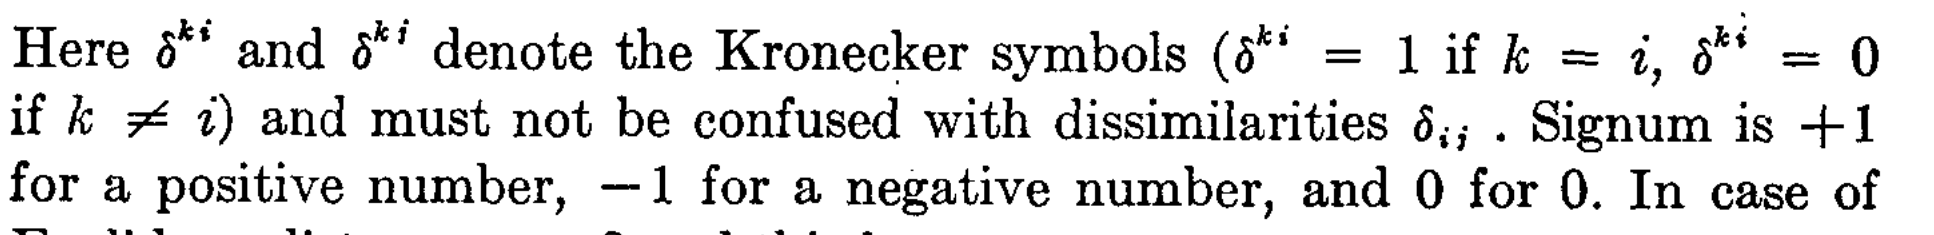
From Kruskal, 1964

In [ ]:
model.trainable_variables

In [ ]:
len(dissimilarity_vec)


In [ ]:
latest_config =  model.trainable_variables[-1]
latest_config  = latest_config.numpy() + np.random.uniform(size = latest_config.shape, low = 0., high = 0.20)


In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(x=latest_config[:,0], y=latest_config[:,1])
for i, label in enumerate(big_matrix.index.to_list()):
       plt.annotate(label, (latest_config[i,0], latest_config[i,1]))

ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

In [ ]:
latest_config

In [ ]:
plt.matshow(model.get_layer('dense').weights[0])

In [ ]:
np.min(model.get_layer('dense').weights[0])